# Hybrid model for Hypertension Risk Prediction
- Use a 24-hour history to predict the next 24 hours of systolic, diastolic (blood pressure prediction) and heart rate
- Use measuring metrics: MAE, MSE, RMSE on systolic, diastolic and heart rate

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pprint import pprint
import gc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from xgboost import XGBRegressor

In [93]:
# Load dataset
data = pd.read_excel("C:/Users/m/OneDrive - The University of Melbourne/Documents/Learning/Research/Mappings.xlsx")
print(data.shape)
data.head()

(18842, 9)


,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender
0,9690,125.0,87.0,98.0,2018-05-16 11:00:00,1973-05-08,96.0,177,M
1,9690,121.0,84.0,39.5,2018-05-16 12:00:00,1973-05-08,96.0,177,M
2,9690,122.5,84.0,44.5,2018-05-16 13:00:00,1973-05-08,96.0,177,M
3,9690,123.0,80.0,80.0,2018-05-16 14:00:00,1973-05-08,96.0,177,M
4,9690,125.0,78.0,72.0,2018-05-16 15:00:00,1973-05-08,96.0,177,M


## Feature Engineering

### Analyse the temporal features

In [94]:
data["DOB"] = pd.to_datetime(data["DOB"])
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

#Calculate age at each timestamp (exact, year-accurate)
data["Age"] = (
    data["Timestamp"].dt.year - data["DOB"].dt.year
    - (
        (data["Timestamp"].dt.month < data["DOB"].dt.month)
        | (
            (data["Timestamp"].dt.month == data["DOB"].dt.month)
            & (data["Timestamp"].dt.day < data["DOB"].dt.day)
        )
    )
)
data["Age"].unique()

array([45, 54, 55, 51, 52, 27], dtype=int32)

In [95]:
# Add time-of-day features
data["Hour"] = data["Timestamp"].dt.hour
#categorise time of day
def time_of_day(hour):
    if 5 <= hour < 12: 
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"
data["Time of day"] = data["Hour"].apply(time_of_day)
data.head()

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,Age,Hour,Time of day
0,9690,125.0,87.0,98.0,2018-05-16 11:00:00,1973-05-08,96.0,177,M,45,11,Morning
1,9690,121.0,84.0,39.5,2018-05-16 12:00:00,1973-05-08,96.0,177,M,45,12,Afternoon
2,9690,122.5,84.0,44.5,2018-05-16 13:00:00,1973-05-08,96.0,177,M,45,13,Afternoon
3,9690,123.0,80.0,80.0,2018-05-16 14:00:00,1973-05-08,96.0,177,M,45,14,Afternoon
4,9690,125.0,78.0,72.0,2018-05-16 15:00:00,1973-05-08,96.0,177,M,45,15,Afternoon


### Analyse the numerical variables

In [96]:
# Calculate Meam Arterial Pressure (MAP)
data["MAP"] = (data["Systolic"] + 2*data["Diastolic"])/3

# Calculate BMI
data["BMI"] = data["Weight"]/ (data["Height"] ** 2)

# Calculate Pulse Pressure
data["Pulse Pressure"] = data["Systolic"] - data["Diastolic"]

data.head()

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,Age,Hour,Time of day,MAP,BMI,Pulse Pressure
0,9690,125.0,87.0,98.0,2018-05-16 11:00:00,1973-05-08,96.0,177,M,45,11,Morning,99.666667,0.003064,38.0
1,9690,121.0,84.0,39.5,2018-05-16 12:00:00,1973-05-08,96.0,177,M,45,12,Afternoon,96.333333,0.003064,37.0
2,9690,122.5,84.0,44.5,2018-05-16 13:00:00,1973-05-08,96.0,177,M,45,13,Afternoon,96.833333,0.003064,38.5
3,9690,123.0,80.0,80.0,2018-05-16 14:00:00,1973-05-08,96.0,177,M,45,14,Afternoon,94.333333,0.003064,43.0
4,9690,125.0,78.0,72.0,2018-05-16 15:00:00,1973-05-08,96.0,177,M,45,15,Afternoon,93.666667,0.003064,47.0


### Analyse the categorical variables

In [97]:
# Encode the Gender
data["Gender"] = data["Gender"].map({"M": 1, "F": 0})

# Encode the time of the day
#Create a function that finds the most common categories
def calculate_top_categories(df, variable, how_many=4): #how_many is a variabe to set a value for how many different columns we want to create
    return [x for x in df[variable].value_counts().sort_values(ascending=False).head(how_many).index]
    
top_categories = calculate_top_categories(data,'Time of day')

def one_hot_encode(df, variable, top_x_label):
    for label in top_x_label:
        df[variable + '_' + label] = (df[variable] == label).astype(int)
    return df
data = one_hot_encode(data, "Time of day", top_categories)
data.head()

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,Age,Hour,Time of day,MAP,BMI,Pulse Pressure,Time of day_Night,Time of day_Morning,Time of day_Afternoon,Time of day_Evening
0,9690,125.0,87.0,98.0,2018-05-16 11:00:00,1973-05-08,96.0,177,1,45,11,Morning,99.666667,0.003064,38.0,0,1,0,0
1,9690,121.0,84.0,39.5,2018-05-16 12:00:00,1973-05-08,96.0,177,1,45,12,Afternoon,96.333333,0.003064,37.0,0,0,1,0
2,9690,122.5,84.0,44.5,2018-05-16 13:00:00,1973-05-08,96.0,177,1,45,13,Afternoon,96.833333,0.003064,38.5,0,0,1,0
3,9690,123.0,80.0,80.0,2018-05-16 14:00:00,1973-05-08,96.0,177,1,45,14,Afternoon,94.333333,0.003064,43.0,0,0,1,0
4,9690,125.0,78.0,72.0,2018-05-16 15:00:00,1973-05-08,96.0,177,1,45,15,Afternoon,93.666667,0.003064,47.0,0,0,1,0


### Analyse the target variables 

In [98]:
# Define a function for blood pressure plot
def plot_bp_user(df, user_id):
    user_df = df[df["UserID"] == user_id].sort_values("Timestamp")

    plt.figure()
    plt.plot(user_df["Timestamp"], user_df["Systolic"], label = "Systolic")
    plt.plot(user_df["Timestamp"], user_df["Diastolic"], label = "Diastolic")
    plt.xlabel("Time")
    plt.xticks(rotation = 45)
    plt.ylabel("Blood Pressure (mmHg)")
    plt.title(f"Blood Pressure Over Time - User {user_id}")
    plt.legend()
    plt.show()

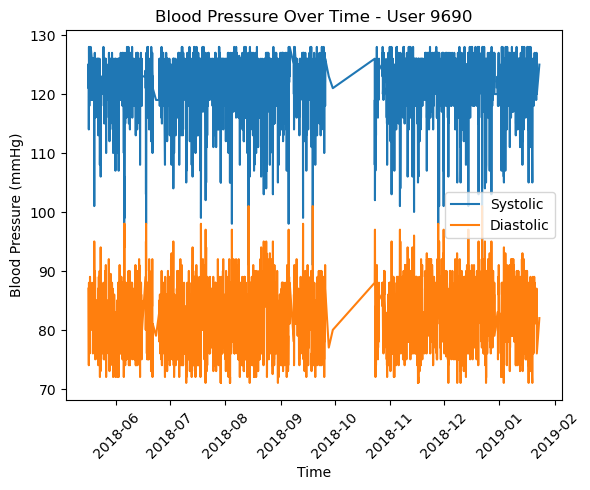

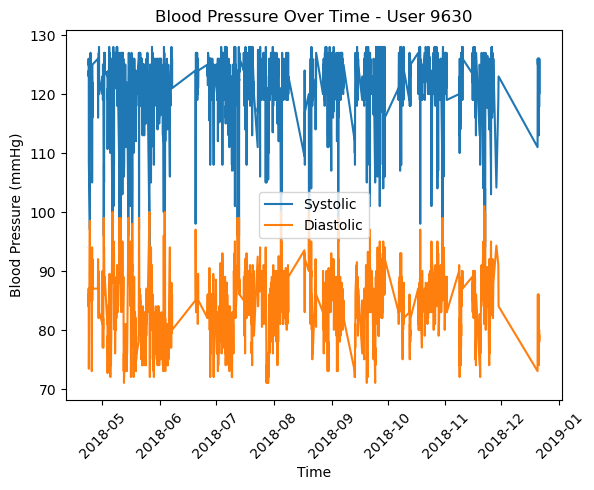

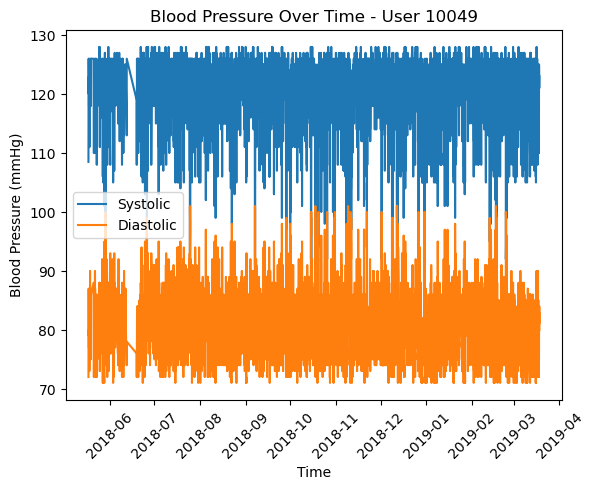

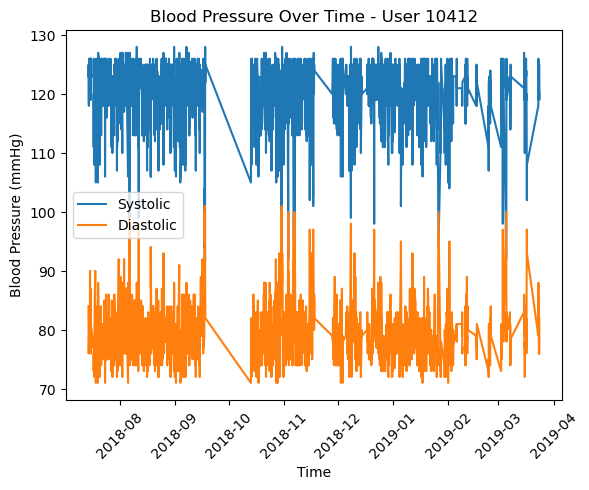

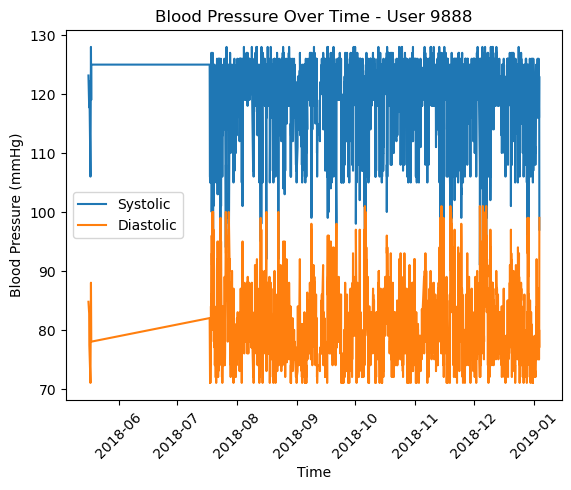

In [99]:
for user in data["UserID"].unique():
    plot_bp_user(data, user)

In [130]:
# Create lagged features
def create_lagged_features(data,value_cols,group_col="UserID",time_col="Timestamp",lags=3):
    df = data.copy()
    df = df.sort_values([group_col, time_col])
    for col in value_cols:
        for lag in range(1, lags + 1):
            df[f"{col}_lag_{lag}"] = (
                df.groupby(group_col)[col].shift(lag) )
    df = df.dropna().reset_index(drop=True)
    return df

lagged_data = create_lagged_features(data, value_cols = ["Systolic", "Diastolic", "Heart Rate"], lags = 3)
print(lagged_data.head())

   UserID  Systolic  Diastolic  Heart Rate           Timestamp        DOB  \
0    9630     123.0       86.5        54.5 2018-04-23 16:00:00 1963-07-06   
1    9630     124.0       82.0        82.0 2018-04-23 17:00:00 1963-07-06   
2    9630     108.4       73.4         0.0 2018-04-23 18:00:00 1963-07-06   
3    9630      97.0       98.5        53.5 2018-04-24 07:00:00 1963-07-06   
4    9630     120.0       90.0       102.0 2018-04-24 08:00:00 1963-07-06   

   Weight  Height  Gender  Age  ...  Time of day_Evening Systolic_lag_1  \
0    83.0     172       1   54  ...                    0          126.0   
1    83.0     172       1   54  ...                    1          123.0   
2    83.0     172       1   54  ...                    1          124.0   
3    83.0     172       1   54  ...                    0          108.4   
4    83.0     172       1   54  ...                    0           97.0   

   Systolic_lag_2  Systolic_lag_3  Diastolic_lag_1  Diastolic_lag_2  \
0           125

### Rolling statistics

In [101]:
# Begin by creating a function to calculate the rolling mean and rolling standard deviation
def add_rolling_features(df, window = 30): # default window of size 3. Expanding the window size impacts the amount
   df = df.sort_values("Timestamp")
   df["Sys_roll"] = df.groupby("UserID")["Systolic"].transform(lambda x: x.rolling(window, min_periods=5).median())
   df["Dia_roll"] = df.groupby("UserID")["Diastolic"].transform(lambda x: x.rolling(window, min_periods=5).median())
   df.dropna(inplace = True) 
   return df
lagged_data = add_rolling_features(lagged_data)
lagged_data.head()

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,Age,...,Systolic_lag_2,Systolic_lag_3,Diastolic_lag_1,Diastolic_lag_2,Diastolic_lag_3,Heart Rate_lag_1,Heart Rate_lag_2,Heart Rate_lag_3,Sys_roll,Dia_roll
4,9630,120.0,90.0,102.0,2018-04-24 08:00:00,1963-07-06,83.0,172,1,54,...,108.4,124.0,98.5,73.4,82.0,53.5,0.0,82.0,120.0,86.50
5,9630,123.0,89.0,106.0,2018-04-24 09:00:00,1963-07-06,83.0,172,1,54,...,97.0,108.4,90.0,98.5,73.4,102.0,53.5,0.0,121.5,87.75
6,9630,119.0,91.0,105.0,2018-04-24 10:00:00,1963-07-06,83.0,172,1,54,...,120.0,97.0,89.0,90.0,98.5,106.0,102.0,53.5,120.0,89.00
7,9630,126.0,87.5,47.5,2018-04-24 11:00:00,1963-07-06,83.0,172,1,54,...,123.0,120.0,91.0,89.0,90.0,105.0,106.0,102.0,121.5,88.25
8,9630,125.0,87.0,92.0,2018-04-24 12:00:00,1963-07-06,83.0,172,1,54,...,119.0,123.0,87.5,91.0,89.0,47.5,105.0,106.0,123.0,87.50


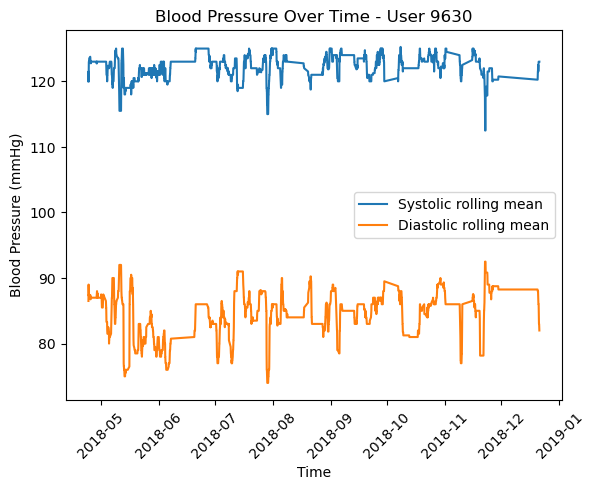

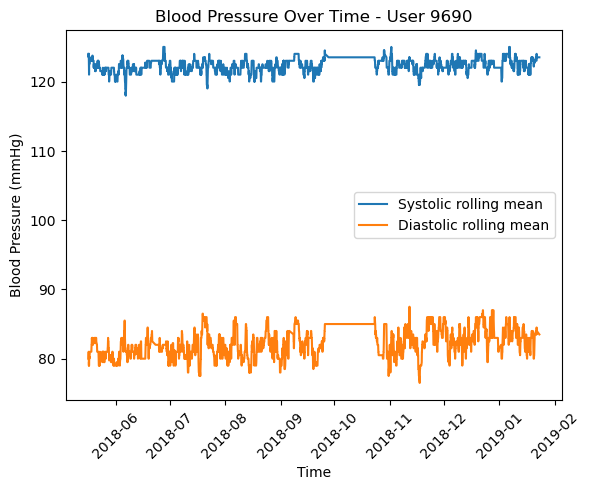

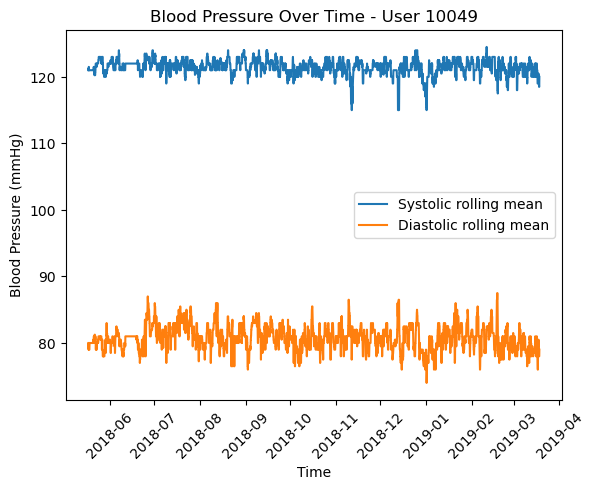

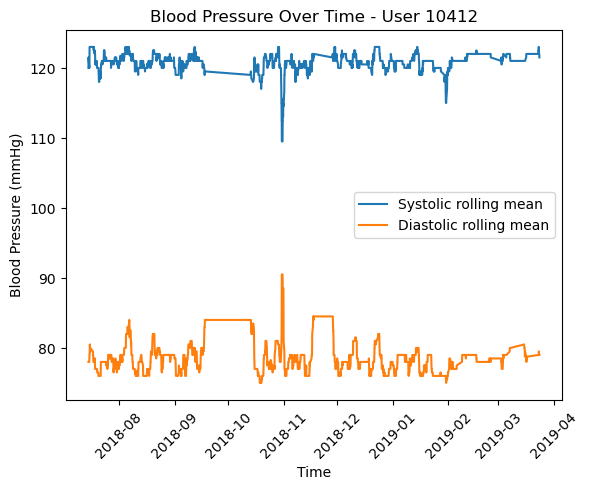

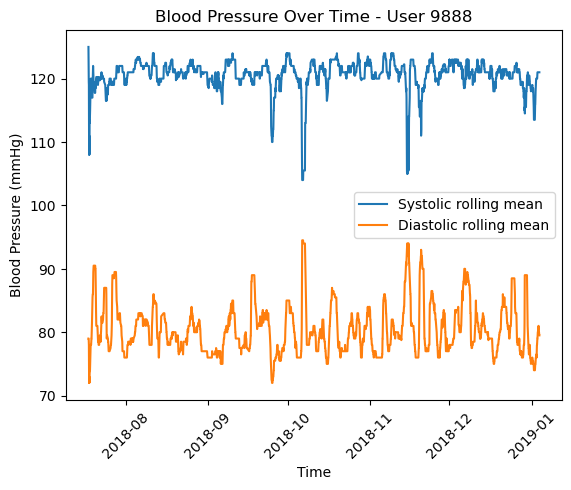

In [102]:
# Plot of the rolling mean
def plot_rollbp_user(df, user_id):
    user_df = df[df["UserID"] == user_id].sort_values("Timestamp")
    plt.figure()
    plt.plot(user_df["Timestamp"], user_df["Sys_roll"], label = "Systolic rolling mean")
    plt.plot(user_df["Timestamp"], user_df["Dia_roll"], label = "Diastolic rolling mean")
    plt.xlabel("Time")
    plt.xticks(rotation = 45)
    plt.ylabel("Blood Pressure (mmHg)")
    plt.title(f"Blood Pressure Over Time - User {user_id}")
    plt.legend()
    plt.show()

for user in lagged_data["UserID"].unique():
    plot_rollbp_user(lagged_data, user)

### Look for relationships in the data

In [103]:
data.head(20)

,UserID,Systolic,Diastolic,Heart Rate,Timestamp,DOB,Weight,Height,Gender,Age,Hour,Time of day,MAP,BMI,Pulse Pressure,Time of day_Night,Time of day_Morning,Time of day_Afternoon,Time of day_Evening
0,9690,125.0,87.0000,98.0,2018-05-16 11:00:00,1973-05-08,96.0,177,1,45,11,Morning,99.666667,0.003064,38.0000,0,1,0,0
1,9690,121.0,84.0000,39.5,2018-05-16 12:00:00,1973-05-08,96.0,177,1,45,12,Afternoon,96.333333,0.003064,37.0000,0,0,1,0
2,9690,122.5,84.0000,44.5,2018-05-16 13:00:00,1973-05-08,96.0,177,1,45,13,Afternoon,96.833333,0.003064,38.5000,0,0,1,0
3,9690,123.0,80.0000,80.0,2018-05-16 14:00:00,1973-05-08,96.0,177,1,45,14,Afternoon,94.333333,0.003064,43.0000,0,0,1,0
4,9690,125.0,78.0000,72.0,2018-05-16 15:00:00,1973-05-08,96.0,177,1,45,15,Afternoon,93.666667,0.003064,47.0000,0,0,1,0
5,9690,114.0,74.0000,64.0,2018-05-16 16:00:00,1973-05-08,96.0,177,1,45,16,Afternoon,87.333333,0.003064,40.0000,0,0,1,0
6,9690,124.0,82.0000,86.0,2018-05-16 17:00:00,1973-05-08,96.0,177,1,45,17,Evening,96.000000,0.003064,42.0000,0,0,0,1
7,9690,128.0,88.0000,97.0,2018-05-16 18:00:00,1973-05-08,96.0,177,1,45,18,Evening,101.333333,0.003064,40.0000,0,0,0,1
8,9690,121.0,83.0000,91.0,2018-05-16 21:00:00,1973-05-08,96.0,177,1,45,21,Night,95.666667,0.003064,38.0000,1,0,0,0
9,9690,126.0,78.0000,80.0,2018-05-16 22:00:00,1973-05-08,96.0,177,1,45,22,Night,94.000000,0.003064,48.0000,1,0,0,0


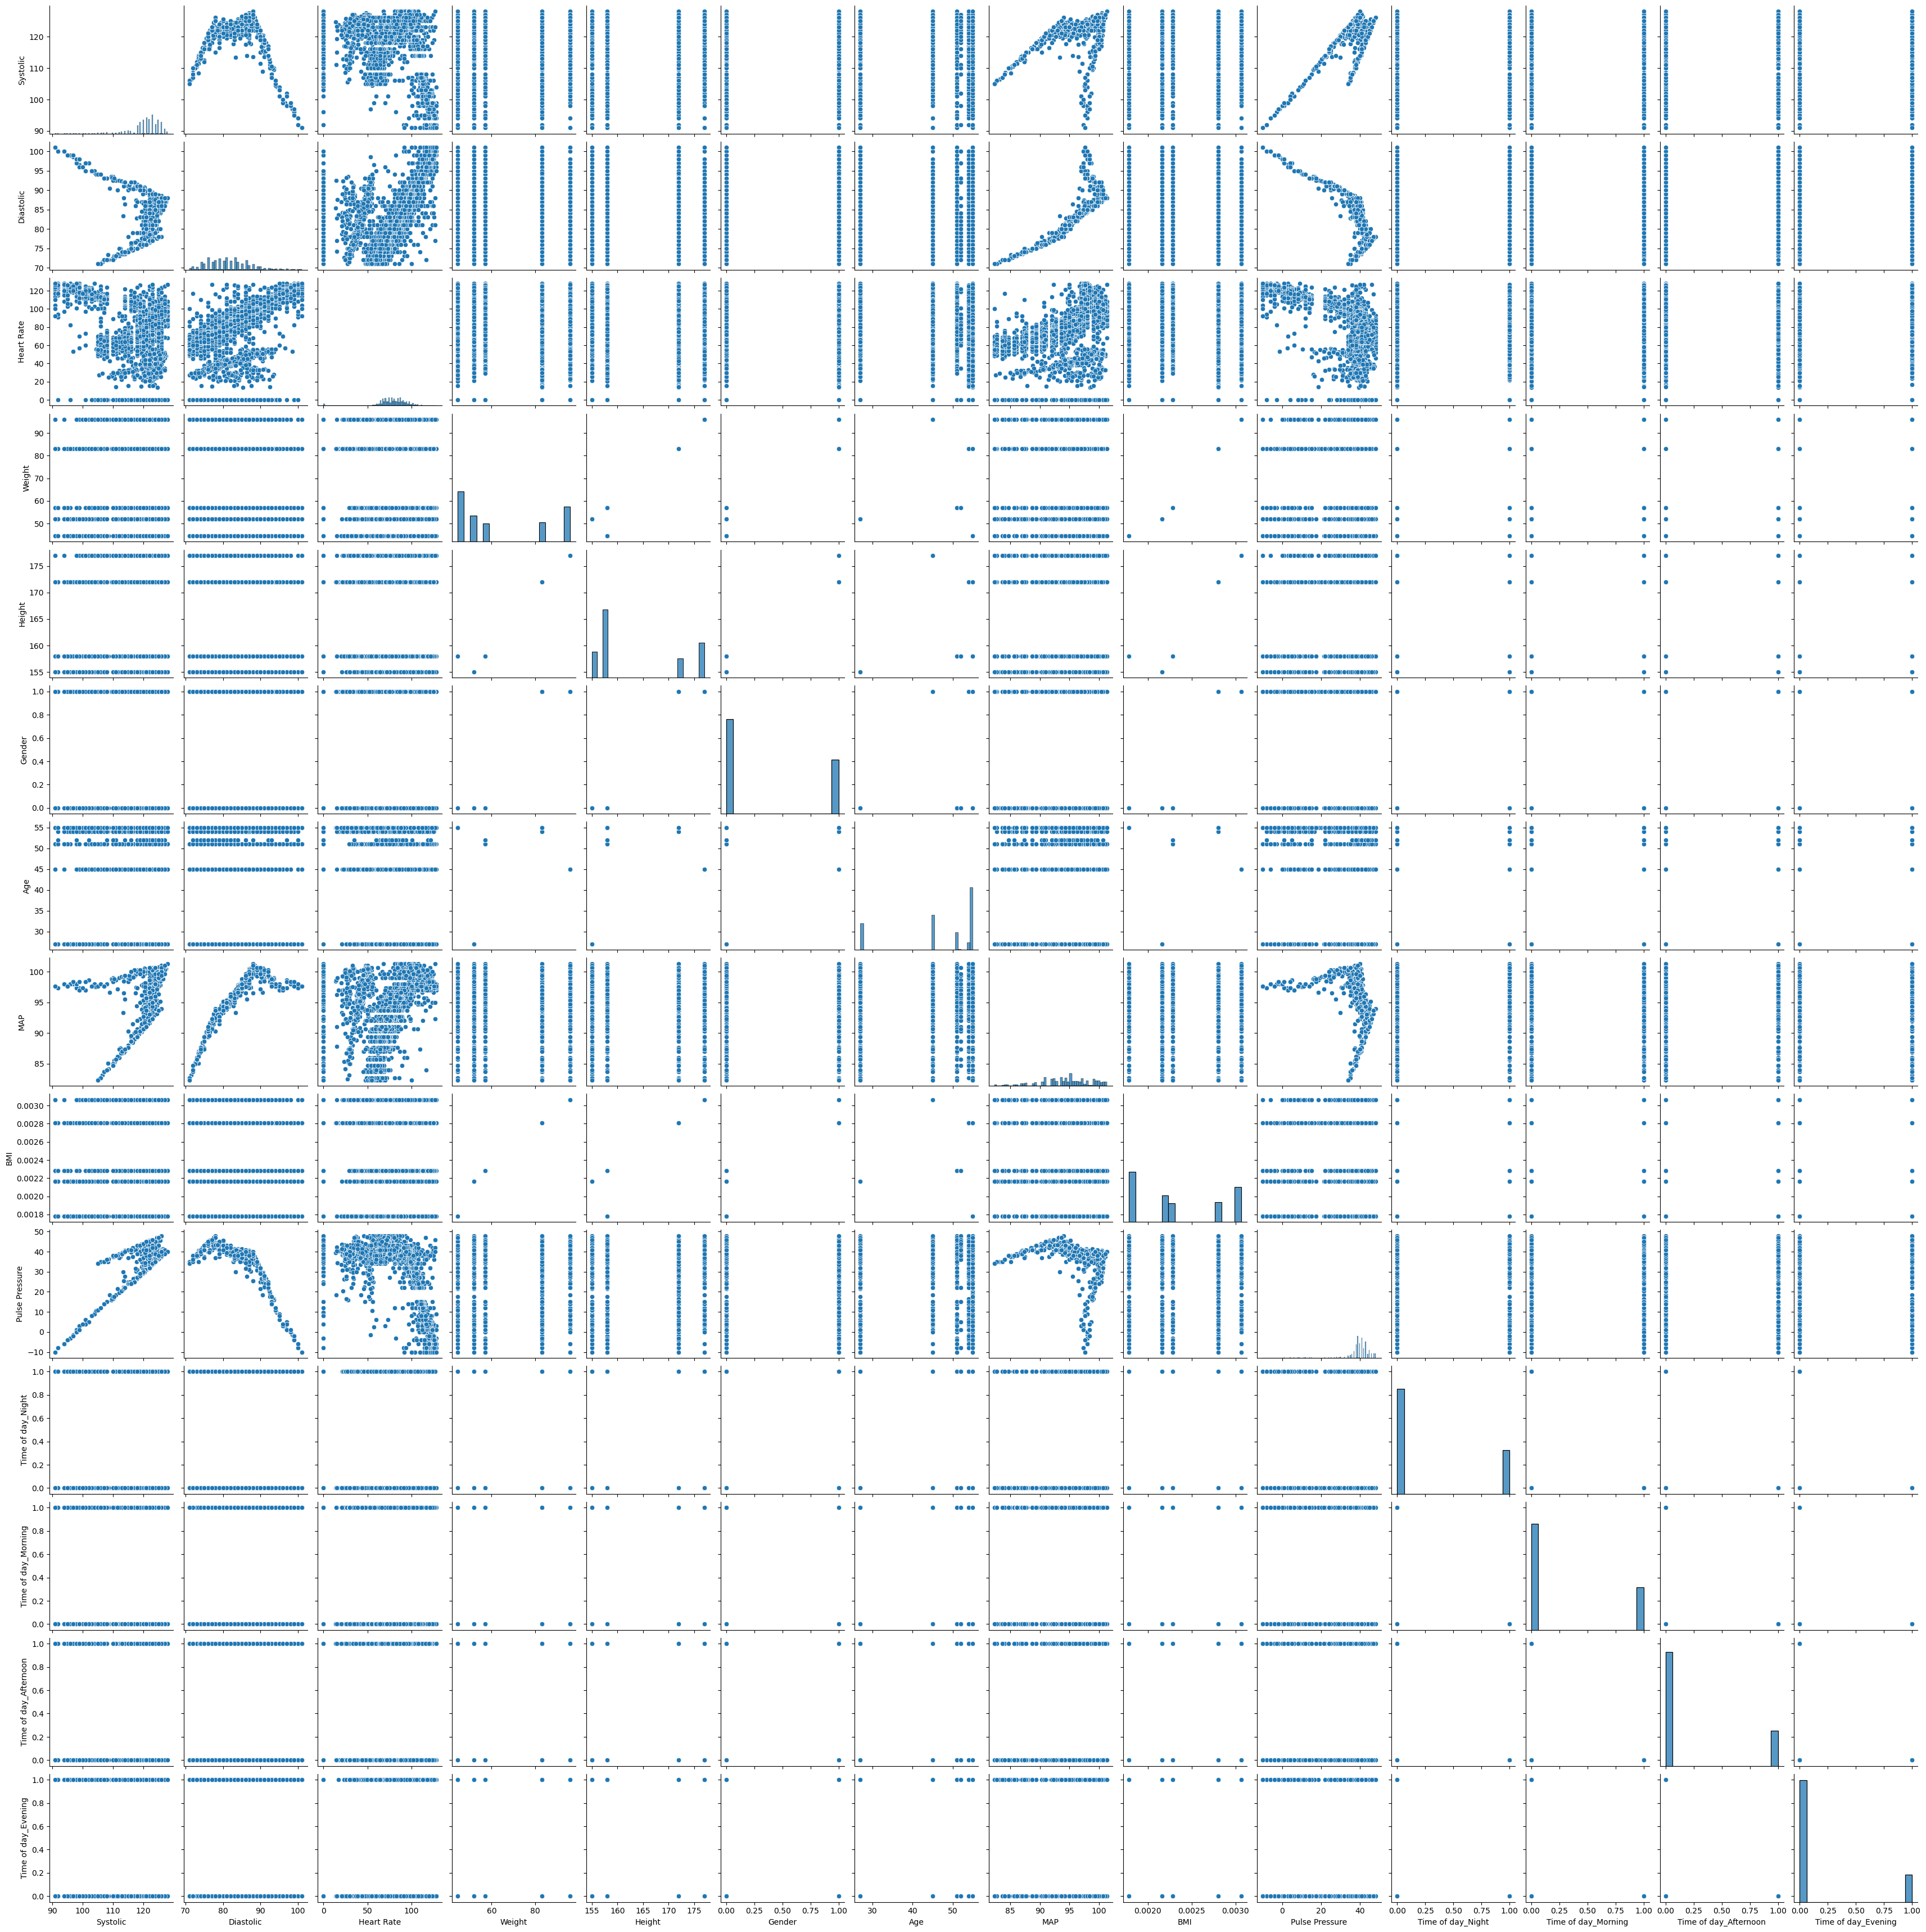

In [105]:
correlation_graph = sns.pairplot(data.drop(["UserID", "Timestamp", "DOB", "Hour", "Time of day"], axis = 1))

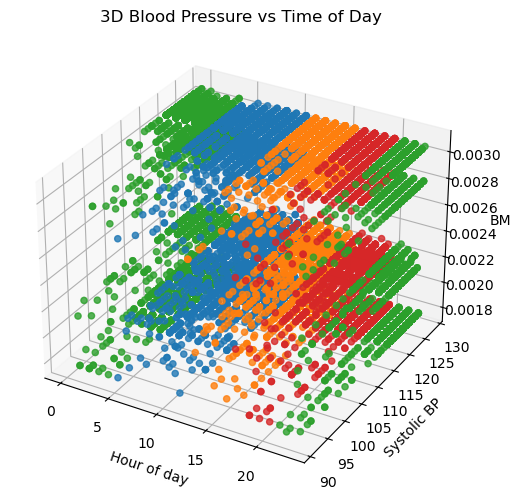

In [119]:
# Plot represents blood pressure (Systolic) changes according to time of day and BMI
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection = "3d")
time_color_map = {"Morning": "tab:blue","Afternoon": "tab:orange","Night": "tab:green", "Evening": "tab:red"}

colors = data["Time of day"].map(time_color_map)


#scatter
ax.scatter(data["Hour"],data["Systolic"],data["BMI"], c = colors, alpha = 0.8)

ax.set_xlabel("Hour of day")
ax.set_ylabel("Systolic BP")
ax.set_zlabel("BMI")
ax.set_title("3D Blood Pressure vs Time of Day")

plt.show()




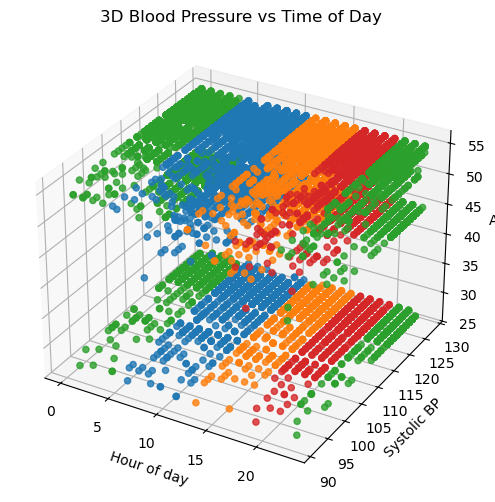

In [121]:
# Plot represents blood pressure (Systolic) changes according to time of day and age
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection = "3d")
time_color_map = {"Morning": "tab:blue","Afternoon": "tab:orange","Night": "tab:green", "Evening": "tab:red"}

colors = data["Time of day"].map(time_color_map)


#scatter
ax.scatter(data["Hour"],data["Systolic"],data["Age"], c = colors, alpha = 0.8)

ax.set_xlabel("Hour of day")
ax.set_ylabel("Systolic BP")
ax.set_zlabel("Age")
ax.set_title("3D Blood Pressure vs Time of Day")

plt.show()


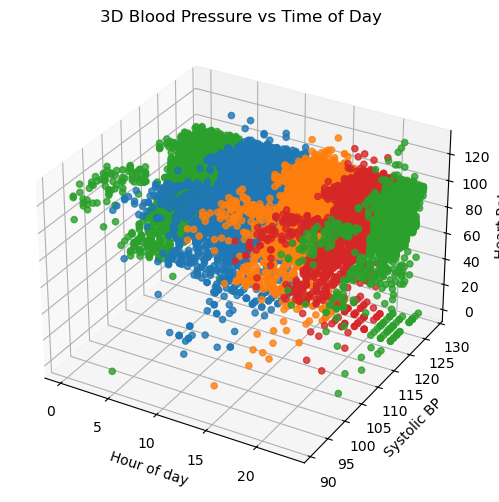

In [122]:
# Plot represents blood pressure (Systolic) changes according to time of day and heart rate
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection = "3d")
time_color_map = {"Morning": "tab:blue","Afternoon": "tab:orange","Night": "tab:green", "Evening": "tab:red"}

colors = data["Time of day"].map(time_color_map)


#scatter
ax.scatter(data["Hour"],data["Systolic"],data["Heart Rate"], c = colors, alpha = 0.8)

ax.set_xlabel("Hour of day")
ax.set_ylabel("Systolic BP")
ax.set_zlabel("Heart Rate")
ax.set_title("3D Blood Pressure vs Time of Day")

plt.show()

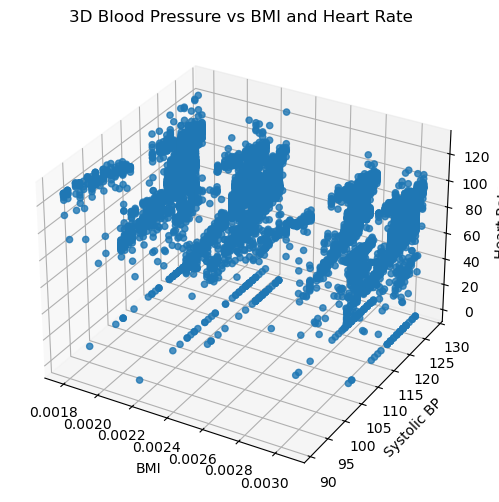

In [136]:
# Plot represents blood pressure (Systolic) changes according to BMI and heart rate
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection = "3d")
time_color_map = {"Morning": "tab:blue","Afternoon": "tab:orange","Night": "tab:green", "Evening": "tab:red"}

colors = data["Time of day"].map(time_color_map)


#scatter
ax.scatter(data["BMI"],data["Systolic"],data["Heart Rate"], alpha = 0.8)

ax.set_xlabel("BMI")
ax.set_ylabel("Systolic BP")
ax.set_zlabel("Heart Rate")
ax.set_title("3D Blood Pressure vs BMI and Heart Rate")

plt.show()

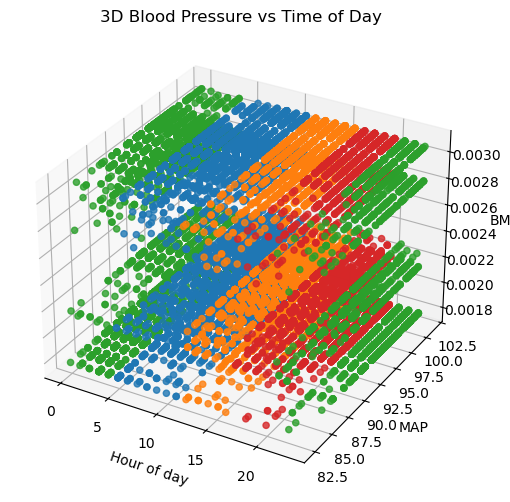

In [138]:
# Plot represents blood pressure (MAP) changes according to time of day and BMI
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection = "3d")
time_color_map = {"Morning": "tab:blue","Afternoon": "tab:orange","Night": "tab:green", "Evening": "tab:red"}

colors = data["Time of day"].map(time_color_map)


#scatter
ax.scatter(data["Hour"],data["MAP"],data["BMI"], c = colors, alpha = 0.8)

ax.set_xlabel("Hour of day")
ax.set_ylabel("MAP")
ax.set_zlabel("BMI")
ax.set_title("3D Blood Pressure vs Time of Day")

plt.show()


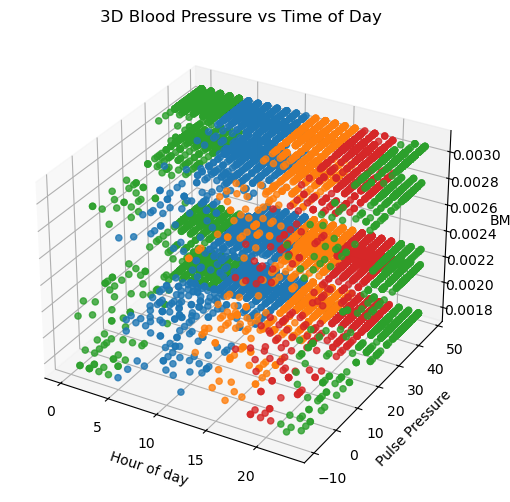

In [139]:
# Plot represents blood pressure (Pulse Pressure) changes according to time of day and BMI
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection = "3d")
time_color_map = {"Morning": "tab:blue","Afternoon": "tab:orange","Night": "tab:green", "Evening": "tab:red"}

colors = data["Time of day"].map(time_color_map)


#scatter
ax.scatter(data["Hour"],data["Pulse Pressure"],data["BMI"], c = colors, alpha = 0.8)

ax.set_xlabel("Hour of day")
ax.set_ylabel("Pulse Pressure")
ax.set_zlabel("BMI")
ax.set_title("3D Blood Pressure vs Time of Day")

plt.show()

## Training the XGBoost model


In [134]:
lagged_data.columns

Index(['UserID', 'Systolic', 'Diastolic', 'Heart Rate', 'Timestamp', 'DOB',
       'Weight', 'Height', 'Gender', 'Age', 'Hour', 'Time of day', 'MAP',
       'BMI', 'Pulse Pressure', 'Time of day_Night', 'Time of day_Morning',
       'Time of day_Afternoon', 'Time of day_Evening', 'Systolic_lag_1',
       'Systolic_lag_2', 'Systolic_lag_3', 'Diastolic_lag_1',
       'Diastolic_lag_2', 'Diastolic_lag_3', 'Heart Rate_lag_1',
       'Heart Rate_lag_2', 'Heart Rate_lag_3'],
      dtype='object')

In [141]:
# Split the data into training and testing sets

# Set data for model
model_data = lagged_data.drop(["UserID", 'Timestamp', 'DOB', 'Time of day', 'MAP',
       'BMI', 'Pulse Pressure'], axis = 1)
train_size = int(len(model_data) * 0.8)
train_data = model_data[:train_size]
test_data = model_data[train_size:]

X_train = train_data.drop(['Systolic', 'Diastolic'], axis=1)
y_train = train_data['Systolic']
X_test = test_data.drop(['Systolic', 'Diastolic'], axis=1)
y_test = test_data['Systolic']

In [142]:
model = XGBRegressor(objective = "reg:squarederror", n_estimators = 100, max_depth = 3, learning_rate = 0.1)
# Train the model using the training data
model.fit(X_train, y_train)
# Use the model to predict the target for the test dataset
y_pred = model.predict(X_test)

### Evaluating the model

In [143]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(X_test.index[[0, -1]])
X_train.index[-1]

Mean Squared Error: 8.148452823899431
Mean Absolute Error: 1.878316410285516
Index([15061, 18826], dtype='int64')


15060

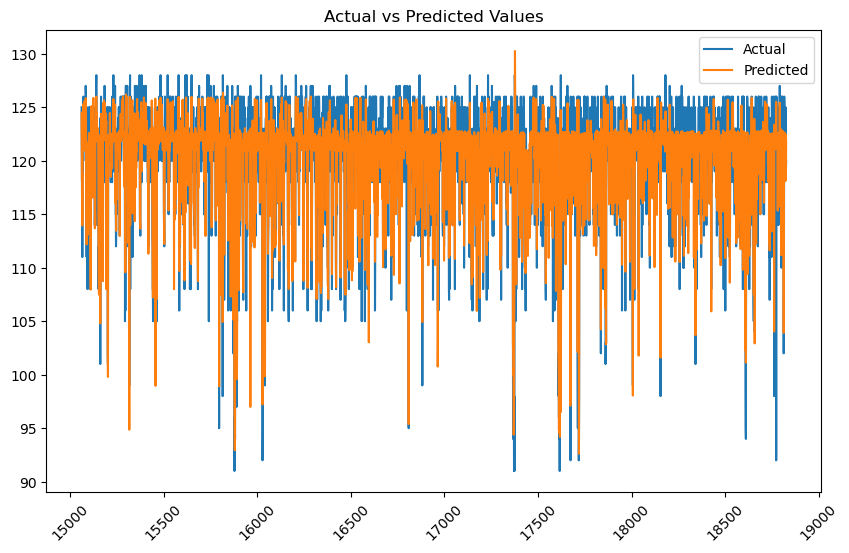

In [144]:
# Plot the predicted values against the actuals to look for gaps between the prediction and actual values
# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xticks(rotation=45)  # Rotate X-axis labels by 45 degrees
plt.legend()
plt.show()